# Моделирование временных рядов

In [1]:
import pandas as pd
import numpy as np

In [2]:
data1 = pd.read_csv('monthly-car-sales-in-quebec-1960.csv')

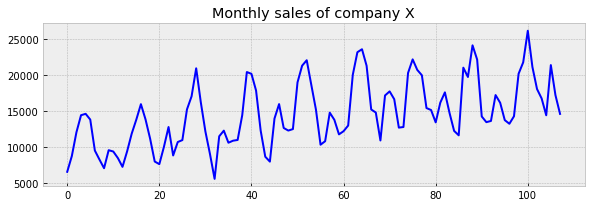

In [3]:
import matplotlib.pyplot as plt
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    x = 1 % 2
    y = int((1 - x) / 2)
        
    ts_ax = plt.subplot2grid(layout, (y, x))
    data1["Count"].plot(ax=ts_ax, color='blue')
    ts_ax.set_title("Monthly sales of company X")
        
plt.tight_layout()

In [4]:
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable

row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(data1['Count'])
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print(itog)

        JB               p-value               skew             kurtosis    
----------------------------------------------------------------------------
3.4945201159396397 0.17425072686303192 0.31500339419302226 2.383841357804773
----------------------------------------------------------------------------


Значение данной статистики свидетельствует о том, нулевая гипотеза о нормальности распределения отвергается с малой вероятностью (probably > 0.05), и, следовательно, наш ряд имеет нормальное распределения.

In [5]:
test = sm.tsa.adfuller(data1['Count'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -1.2238127661752831
p-value:  0.6632691049832871
Critical values:  {'1%': -3.5011373281819504, '5%': -2.8924800524857854, '10%': -2.5832749307479226}
есть единичные корни, ряд не стационарен


In [6]:
diff1 = data1['Count'].diff(periods=1).dropna()

In [7]:
test1 = sm.tsa.adfuller(diff1)
print('adf: ', test1[0])
print('p-value: ', test1[1])
print('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -6.1997992308006955
p-value:  5.8447525992768446e-08
Critical values:  {'1%': -3.5011373281819504, '5%': -2.8924800524857854, '10%': -2.5832749307479226}
единичных корней нет, ряд стационарен


In [8]:
m1 = diff1.index[len(diff1.index)//2+1]
r1 = sm.stats.DescrStatsW(diff1[m1:])
r2 = sm.stats.DescrStatsW(diff1[:m1])
print('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1])

p-value:  0.9829654540772548


Высокое p-value дает нам возможность утверждать, что нулевая гипотеза о равенстве средних верна, что свидетельствует о стационарности ряда. Осталось убедиться в отсутствии тренда и сезонности для этого построим график нашего нового ряда:

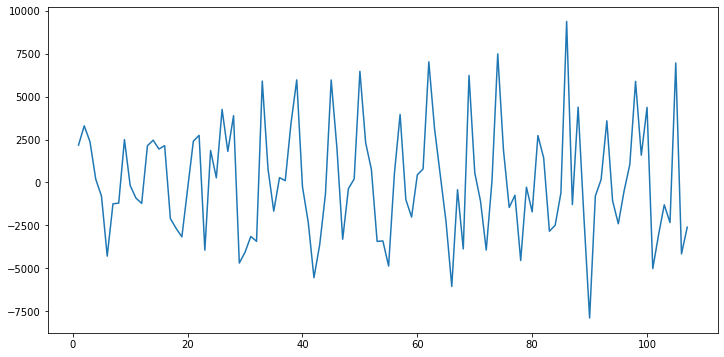

In [9]:
diff1.plot(figsize=(12,6))
plt.show()

Для моделирования будем использовать модель ARIMA интегрированная модель авторегрессии — скользящего среднего — модель и методология анализа временных рядов.

In [10]:
import statsmodels.tsa.api as smt
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

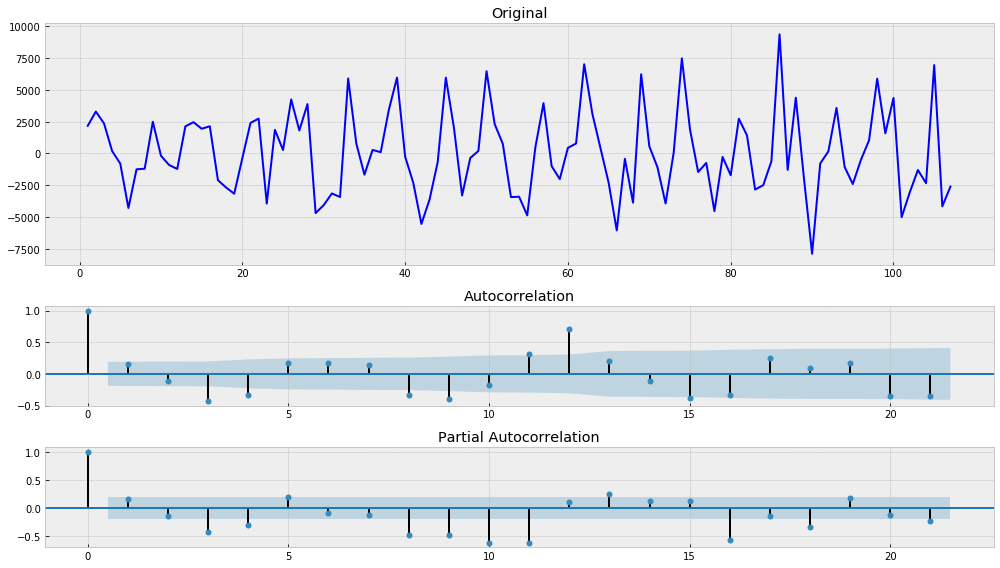

In [11]:
tsplot(diff1)

In [12]:
data1.head()

,Month,Count
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


In [13]:
data1.Month.min()

'1960-01'

In [14]:
data1.Month.max()

'1968-12'

тройное экспоненциальное сглаживаниею или метод Хольта-Винтера - учитывает сезонность, поэтому будем использовать его

In [15]:
class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [16]:
def initial_trend(series, season_len):
    for i in range(season_len):
        return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [17]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [18]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [19]:
def plot_tema(alpha, beta, gamma, ser=data1["Count"], ser_to_plot=data1["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

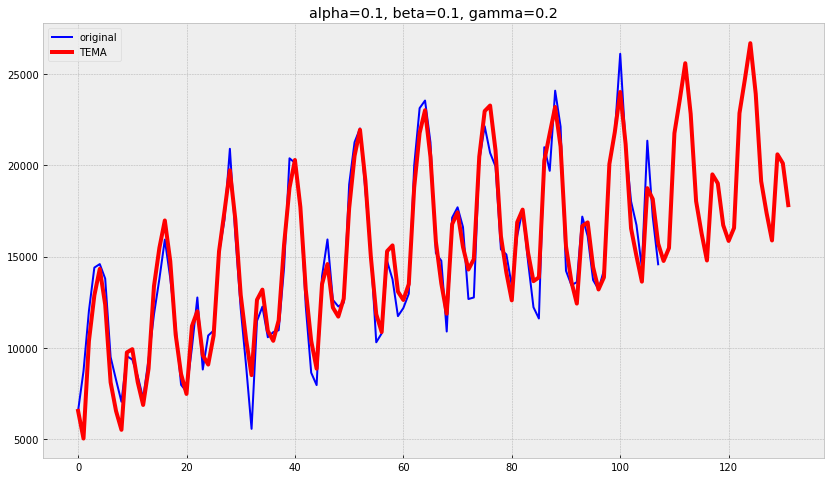

In [20]:
plot_tema(0.1, 0.1, 0.2)

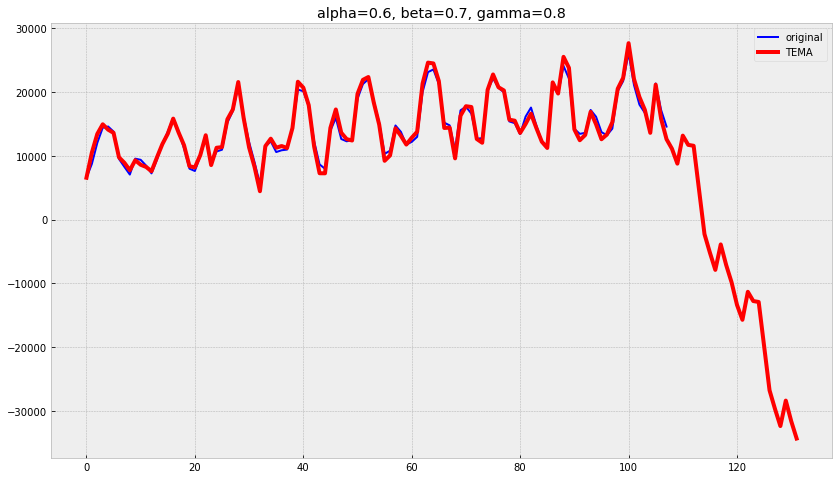

In [21]:
plot_tema(0.6, 0.7, 0.8)

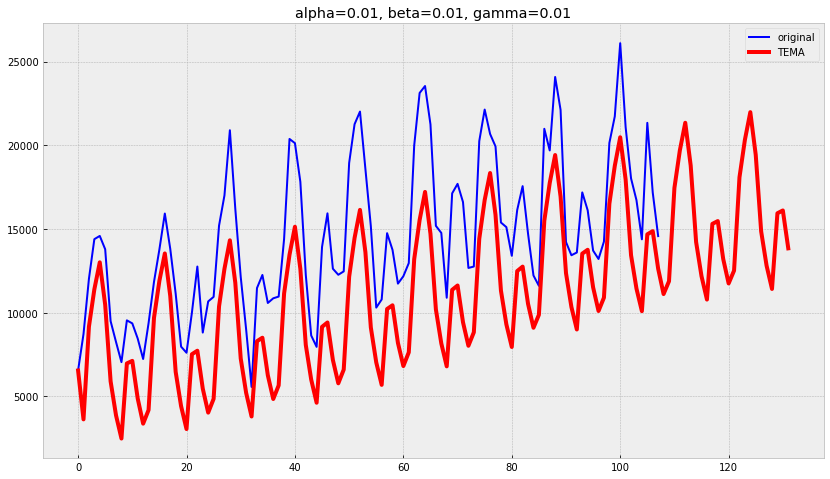

In [22]:
plot_tema(0.01, 0.01, 0.01)

для оценки качества будем использовать rmse

Алгоритм поиска стандартный - метод градиентного спуска. Считаем производный по каждому из параметров и спускаемся в сторону минимума.

In [23]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [24]:
series = data1["Count"]

In [25]:
train, test, val = series[:60], series[60:70], series[70:]

In [26]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [27]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [28]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 7673668.455391444
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.30385160e+00,  1.21071935e+00, -1.80455855e+04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 104
      nit: 16
     njev: 26
   status: 0
  success: True
        x: array([0.64745897, 0.02047504, 1.        ])


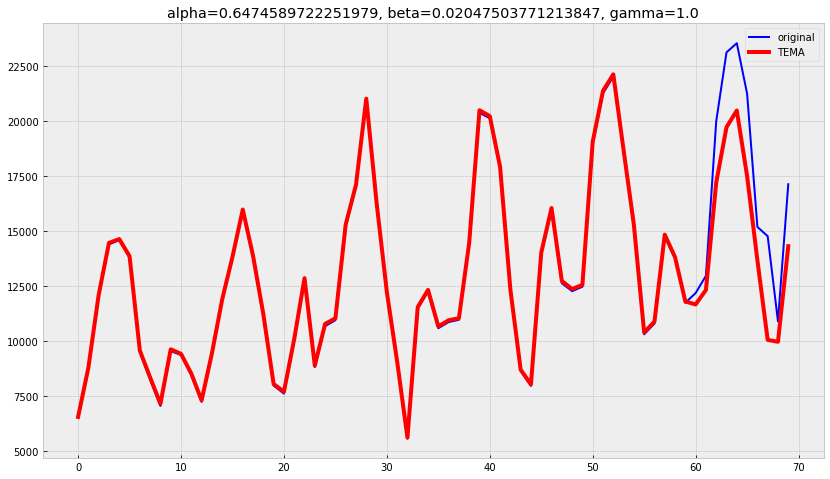

In [29]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:70], n_preds=len(test))

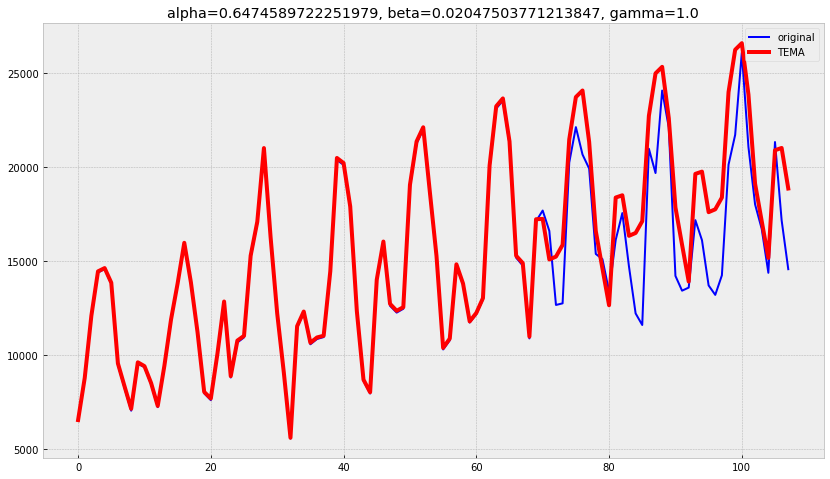

In [30]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:70], ser_to_plot=series, n_preds=len(val))

Теперь будем исследовать тот же набор данных, только уже стационарный ряд

### скользящее среднее

In [79]:
diff2=pd.DataFrame([])
diff2['Month'] = data1['Month']
diff2['Count'] = data1['Count'].diff(periods=1).dropna()
diff2

,Month,Count
0,1960-01,NaN
1,1960-02,2178.0
2,1960-03,3298.0
3,1960-04,2369.0
4,1960-05,192.0
...,...,...
103,1968-08,-1302.0
104,1968-09,-2337.0
105,1968-10,6957.0
106,1968-11,-4162.0


In [80]:
def moving_average(series, n):
    """ Функция для определения среднего по окну"""
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [82]:
def weighted_moving_average(series, n, weights):
    """ Функция принимающая веса и возвращающая скользящее среднее"""
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

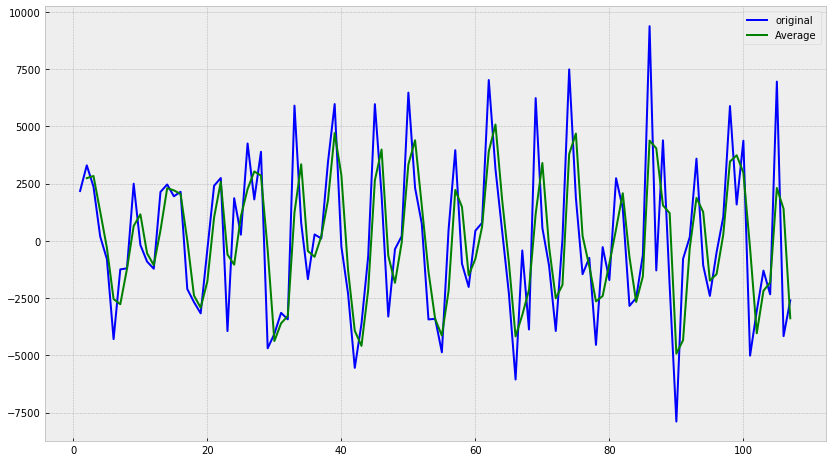

In [103]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(diff2["Count"], color='blue',label='original')
    plt.plot(moving_average(diff2["Count"], 2), color='green', label='Average')
    plt.legend()

In [123]:
series2 = data1["Count"]

In [125]:
train, test, val = series2[:60], series2[60:70], series2[70:]

In [126]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 7673668.455391444
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.30385160e+00,  1.21071935e+00, -1.80455855e+04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 104
      nit: 16
     njev: 26
   status: 0
  success: True
        x: array([0.64745897, 0.02047504, 1.        ])


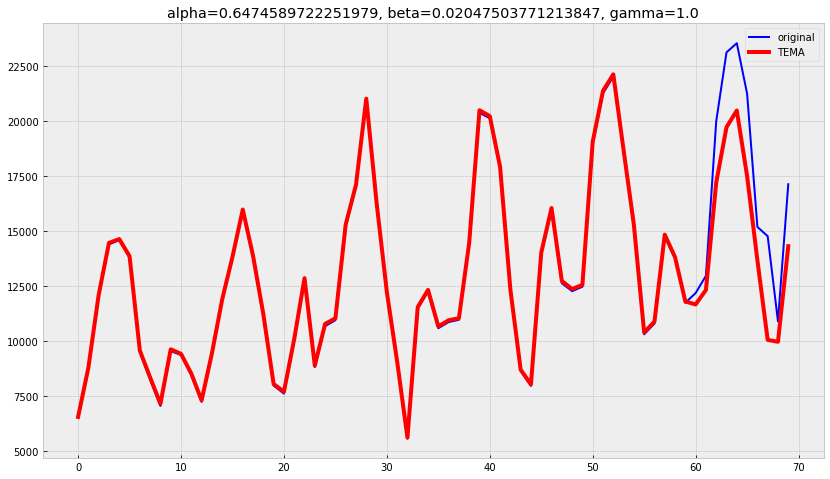

In [127]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:70], n_preds=len(test))

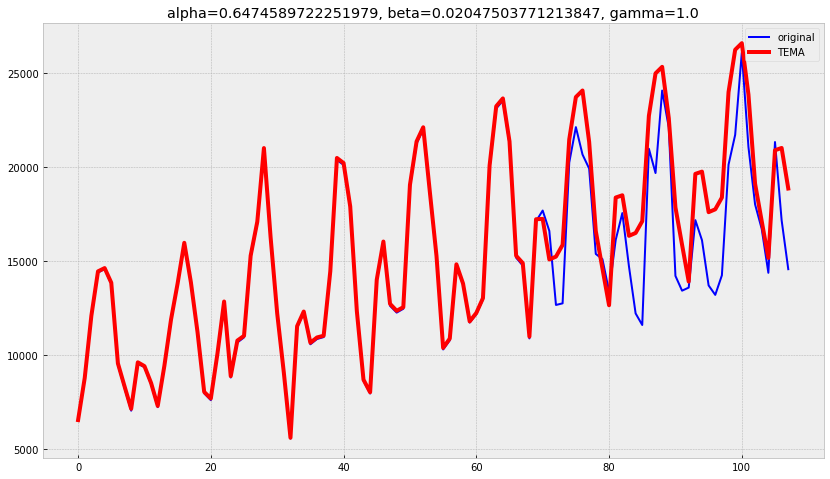

In [128]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:70], ser_to_plot=series, n_preds=len(val))

### двойное экспотенциальное зглаживание

In [120]:
def exponential_moving_average(series, alpha):
    """Двойное экспотенциальное сглаживание"""
    result = [series[0]]
    n=1
    for n in range(1, len(series)):
        result.append(alpha * int(series[n]) + (1 - alpha) * result[n-1])
        n+=1
    return pd.Series(result)

In [121]:
ema = exponential_moving_average(diff2['Count'], 0.2)
print(ema)

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
103   NaN
104   NaN
105   NaN
106   NaN
107   NaN
Length: 108, dtype: float64


In [117]:
diff2['Count'][2]

3298.0

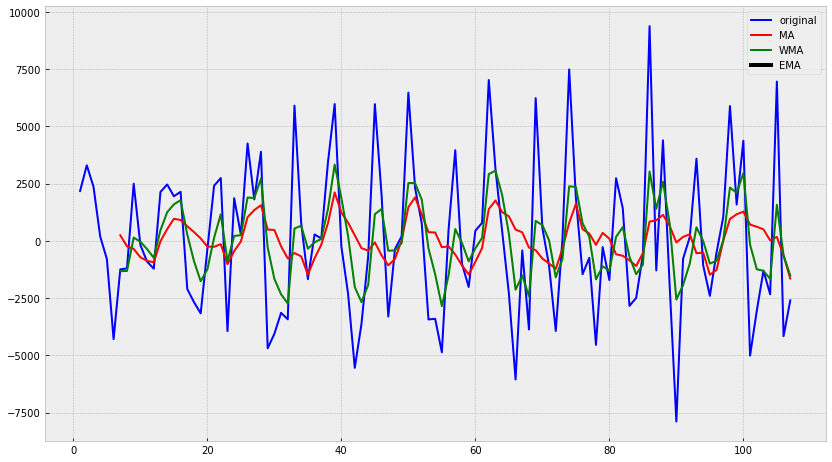

In [122]:
ema = exponential_moving_average(diff2["Count"], 0.3)
wma = weighted_moving_average(diff2["Count"], 7, [1,1,2,3,5,8,13])
ma = moving_average(diff2["Count"], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(diff2["Count"], color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

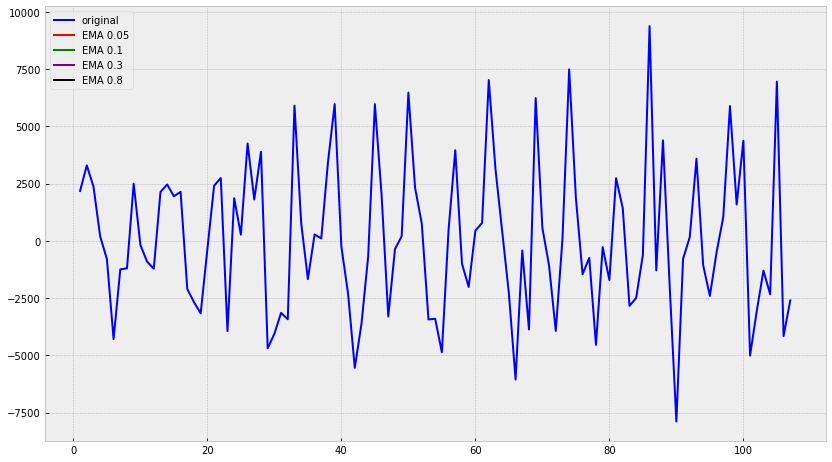

In [89]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(diff2["Count"], color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(diff2["Count"], alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.legend()